In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
import torch.optim as optim
import os
import random
import cv2
import numpy as np

In [2]:
class_label_real = 0
class_label_attack = 1

In [3]:
data_path_train_real = '/home/taha/FASdatasets/Sohail/Replay-Mobile/train/real'
data_path_train_attack = '/home/taha/FASdatasets/Sohail/Replay-Mobile/train/attack'

data_path_devel_real = '/home/taha/FASdatasets/Sohail/Replay-Mobile/devel/real'
data_path_devel_attack = '/home/taha/FASdatasets/Sohail/Replay-Mobile/devel/attack'

data_path_test_real = '/home/taha/FASdatasets/Sohail/Replay-Mobile/test/real'
data_path_test_attack = '/home/taha/FASdatasets/Sohail/Replay-Mobile/test/attack'

In [4]:
def load_samples(path, class_label, transform): #Select N frames returned from read_all_frames and assign labels to all samples of same class
        frames = read_all_frames(path)
        total_frames = list(range(0, frames.shape[0], 1))
        selected_samples = random.sample(total_frames, 1)
        samples =[]
        # Assign the same class label to all samples
        label = class_label
        samples =(transform(frames[selected_samples].squeeze()), label)     
        return samples

def read_all_frames(video_path): # _read_all_frames reads all frames from a  particular video, resizes them to 64x64, and converts them to PyTorch tensors.
    frame_list = []
    video = cv2.VideoCapture(video_path)
    success = True
    while success:
        success, frame = video.read()
        if success:
            frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)
            frame_list.append(frame)
    frame_list = np.array(frame_list)
    return frame_list

class VideoDataset(Dataset):
    def __init__(self, data_path, class_label):
        self.data_path = data_path #path for directory containing video files
        self.video_files = [file for file in os.listdir(data_path) if file.endswith('.mov')] #list of video files in the specified directory
        self.class_label = class_label #manually assign class_label for your desired class while loading
        self.data_length = len(self.video_files) #*num_frames
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self): #Returns the total number of samples in the dataset
        return self.data_length
        # return len(self.samples)

    def __getitem__(self, idx):
        file = self.video_files[idx]
        path = os.path.join(self.data_path, file)
        frames= load_samples(path, self.class_label, self.transform)

        return frames

In [6]:
# Create datasets and data loaders
train_dataset_real = VideoDataset(data_path_train_real, class_label_real)
train_dataset_attack = VideoDataset(data_path_train_attack, class_label_attack)

val_dataset_real = VideoDataset(data_path_devel_real, class_label_real)
val_dataset_attack = VideoDataset(data_path_devel_attack, class_label_attack)

test_dataset_real = VideoDataset(data_path_test_real, class_label_real)
test_dataset_attack = VideoDataset(data_path_test_attack, class_label_attack)

In [7]:
train_loader_real = DataLoader(train_dataset_real, batch_size=1, shuffle=True)
train_loader_attack = DataLoader(train_dataset_attack, batch_size=1, shuffle=True)

val_loader_real = DataLoader(val_dataset_real, batch_size=1, shuffle=False)
val_loader_attack = DataLoader(val_dataset_attack, batch_size=1, shuffle=False)

test_loader_real = DataLoader(test_dataset_real, batch_size=1, shuffle=False)
test_loader_attack = DataLoader(test_dataset_attack, batch_size=1, shuffle=False)

In [8]:
# Concatenate datasets
concatenated_train_dataset = ConcatDataset([train_dataset_real, train_dataset_attack])
concatenated_val_dataset = ConcatDataset([val_dataset_real, val_dataset_attack])
concatenated_test_dataset = ConcatDataset([test_dataset_real, test_dataset_attack])


# Create a DataLoader for the concatenated dataset
concatenated_train_loader = DataLoader(concatenated_train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=8)
concatenated_val_loader = DataLoader(concatenated_val_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=8)
concatenated_test_loader = DataLoader(concatenated_test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=8)

Replay Mobile DataSet:

Training -> 312 (Real 120, Attack 192) ->  312/1030 * 100 = 30.29%

Validation -> 416 (Real 160, Attack 256) -> 416/1030 * 100 = 40.38%

Testing -> 302 (Real 110, Attack 192) -> 302/1030 * 100 = 29.32%

Total = 1030

In [9]:
# Print dataset sizes
print(f"Training set size: {len(concatenated_train_dataset)}")
print(f"Validation set size: {len(concatenated_val_dataset)}")
print(f"Test set size: {len(concatenated_test_dataset)}")

Training set size: 312
Validation set size: 416
Test set size: 302


In [10]:
import torchvision.ops

class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    
    def forward(self, x):
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.

        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator
                                          )
        return x

https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

In [11]:
# frame size 224, 224

class Custom_CNN_Model(nn.Module):
    def __init__(self, 
                 deformable=False):
        super(Custom_CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        
        self.conv4 = conv(32, 32, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.conv5 = conv(32, 32, kernel_size=3, stride=1, padding=1)
        self.act5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2)
 
        self.flat = nn.Flatten()
 
        self.fc6 = nn.Linear(401408, 512)
        self.act6 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
 
        self.fc7 = nn.Linear(in_features=512, out_features=2)
 
    def forward(self, x):
        # input 3x224x224, output 32x224x224
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x224x224, output 32x224x224
        x = self.act2(self.conv2(x))
        # input 32x224x224, output 32x224x224
        x = self.act3(self.conv3(x))
        # input 32x224x224, output 32x224x224
        x = self.act4(self.conv4(x))
        # input 32x224x224, output 32x224x224
        x = self.act5(self.conv5(x))
        # input 32x224x224, output 32x112x112
        x = self.pool5(x)
        # input 32x112x112, output 401408 (32*112*112 = 401,408)
        x = self.flat(x)
        # input 401408, output 512
        x = self.act6(self.fc6(x))
        x = self.drop2(x)
        # input 512, output 2
        x = self.fc7(x)
        return x


In [12]:
model = Custom_CNN_Model(deformable=True)
print(model)

Custom_CNN_Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): DeformableConv2d(
    (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (act4): ReLU()
  (conv5): DeformableConv2d(
    (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (regular_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (act5): ReLU()
  (pool5): MaxPool2d

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
#Training loop
epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


# Set up early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
best_loss = float('inf') #set to positive infinity to ensure that the first validation loss encountered will always be considered an improvement
counter = 0  # Counter to keep track of consecutive epochs with no improvement

#Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    train_correct_predictions = 0
    total_train_samples = 0

    for train_images, train_labels in concatenated_train_loader:
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_images)
        # Find the Loss
        train_loss = criterion(train_outputs, train_labels)
        # Calculate gradients
        train_loss.backward()
        # Update Weights
        optimizer.step()

        # accumulate the training loss
        running_loss += train_loss.item()

        # calculate training accuracy
        _, train_predicted = torch.max(train_outputs, 1) # _ contain max value, train_predicted contain the indices where maximum value occured
        train_correct_predictions += (train_predicted == train_labels).sum().item() 
        total_train_samples += train_labels.size(0)
            
    train_total_loss = running_loss / len(concatenated_train_loader)
    train_accuracy = train_correct_predictions / total_train_samples * 100
    train_losses.append(train_total_loss)
    train_accuracies.append(train_accuracy)

    
    #Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_prediction = 0
    total_val_samples = 0
    val_total_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in concatenated_val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_op = model(val_images)
            val_loss = criterion(val_op, val_labels)
            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_op, 1)
            val_correct_prediction += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
        
        val_total_loss = val_running_loss / len(concatenated_val_loader)
        val_accuracy = val_correct_prediction / total_val_samples * 100
        val_losses.append(val_total_loss)
        val_accuracies.append(val_accuracy)

    # Check if validation loss has improved
    if val_total_loss < best_loss:
        best_loss = val_total_loss
        counter = 0
        # Save the model if needed
        # torch.save(model.state_dict(), 'best_model.pth')

    else:
        counter += 1

        # Check if training should be stopped
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break


    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_total_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_total_loss: .4f}, Best Loss: {best_loss: .4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1/50, Training Loss: 1.4146, Training Accuracy: 62.82%, Validation Loss:  0.4687, Best Loss:  0.4687, Validation Accuracy: 86.54%
Epoch 2/50, Training Loss: 0.4508, Training Accuracy: 83.65%, Validation Loss:  0.3682, Best Loss:  0.3682, Validation Accuracy: 85.82%
Epoch 3/50, Training Loss: 0.3499, Training Accuracy: 83.97%, Validation Loss:  0.2997, Best Loss:  0.2997, Validation Accuracy: 93.99%
Epoch 4/50, Training Loss: 0.2175, Training Accuracy: 89.74%, Validation Loss:  0.1939, Best Loss:  0.1939, Validation Accuracy: 94.47%
Epoch 5/50, Training Loss: 0.2053, Training Accuracy: 91.67%, Validation Loss:  0.1492, Best Loss:  0.1492, Validation Accuracy: 93.99%
Epoch 6/50, Training Loss: 0.1971, Training Accuracy: 93.27%, Validation Loss:  0.1151, Best Loss:  0.1151, Validation Accuracy: 98.08%
Epoch 7/50, Training Loss: 0.2233, Training Accuracy: 93.91%, Validation Loss:  0.1120, Best Loss:  0.1120, Validation Accuracy: 96.88%
Epoch 8/50, Training Loss: 0.1161, Training Accu

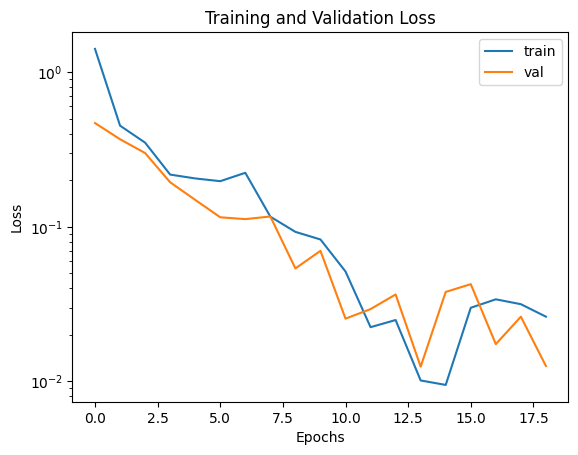

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
# plt.grid(True)
plt.legend()
plt.show()

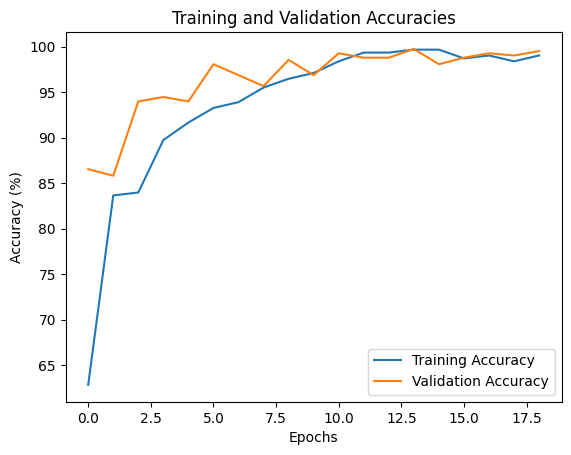

In [23]:
plt.figure()
plt.title("Training and Validation Accuracies")
plt.plot(train_accuracies,label="Training Accuracy")
plt.plot(val_accuracies,label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [17]:
# Evaluate on the test set
test_correct = 0
test_total = 0

model.eval()
with torch.no_grad():
    
    test_cat_labels = torch.empty(0, dtype=torch.int64, device=device)
    test_predicted_cat_labels = torch.empty(0, dtype=torch.int64, device=device)

    for test_images, test_labels in concatenated_test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_model_op = model(test_images)
        _, test_predicted = torch.max(test_model_op, 1)
        test_correct += (test_predicted == test_labels).sum().item() 
        test_total += test_labels.size(0)

        test_cat_labels = torch.cat((test_cat_labels, test_labels))
        test_predicted_cat_labels = torch.cat((test_predicted_cat_labels, test_predicted))

    test_accuracy = test_correct / test_total * 100  
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 97.35%


In [18]:
print(test_cat_labels)
print(test_predicted_cat_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
test_cat_labels_cpu = test_cat_labels.cpu()
test_predicted_cat_labels_cpu = test_predicted_cat_labels.cpu()

print(test_cat_labels_cpu)
print(test_predicted_cat_labels_cpu)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [21]:
tn, fp, fn, tp = confusion_matrix(test_cat_labels_cpu, test_predicted_cat_labels_cpu).ravel()

print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

acc_score = accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
prec_score = precision_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)
recall = recall_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)

Y_I_val =(tp/(tp+fn)) + (tn/(tn+fp)) - 1
sensitivity_val = tp / (tp + fn)
specificity_val = tn / (tn + fp)
f1score_val = 2 * tp / (2 * tp + fp + fn)
FAR = fp/(fp + tn)
FRR = fn/(fn + tp)
HTER_val = (FAR + FRR)/2
EER = (fp+fn)/(tn+fp+fn+tp)
val_bacc = balanced_accuracy_score(test_cat_labels_cpu, test_predicted_cat_labels_cpu)


print('Testing Results')
print(70*'-')
print('Acc:', acc_score, 'Prec:', prec_score, 'Recall:', recall, 'YI:', Y_I_val, 'Sen:', sensitivity_val, 'Spe:', specificity_val, '\n F1:', f1score_val, 'HTER:', HTER_val, 'EER:', EER, 'BACC:', val_bacc)

TN: 104, FP: 6, FN: 2, TP: 190
Testing Results
----------------------------------------------------------------------
Acc: 0.9735099337748344 Prec: 0.9693877551020408 Recall: 0.9895833333333334 YI: 0.9350378787878788 Sen: 0.9895833333333334 Spe: 0.9454545454545454 
 F1: 0.979381443298969 HTER: 0.032481060606060604 EER: 0.026490066225165563 BACC: 0.9675189393939394
